In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import pickle

Plot: matplotlib

sklearn: preprocessing data, linear model

save and load model: pickle

# Utils

In [ ]:
def get_stock_data(tickers: list, start_date: str, end_date: str):
    """
    Download stock data from Yahoo Finance API and save data in csv.

    Parameters:
    -- start: start date "Year-Month-Day"
    -- end: end date "Year-Month-Day"
    -- stock: The label of the stock to download from yahoo stocks

    Return:
    -- all_data: DataFrame containing all stock data
    """
    all_data = pd.DataFrame()

    for ticker in tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date)

        stock_data["Ticker"] = ticker

        all_data = pd.concat([all_data, stock_data])

    all_data.to_csv("stock_data.csv")

    return all_data

def preprocess_data(stock_data):
    """
    Preprocess stock data.

    Parameters:
    -- stock_data: DataFrame containing stock data

    Return:
    -- preprocessed_data: DataFrame containing preprocessed stock data
    """
    preprocessed_data = stock_data.dropna()
    preprocessed_data = preprocessed_data.drop(columns=['Ticker'])

    return preprocessed_data

def split_dataset(stock_data, train_size=0.8, num_days_prediction=3):
    """
    Split stock data into training and testing datasets and save in csv.

    Parameters:
    -- stock_data: DataFrame containing stock data
    -- train_size: The size of the training dataset
    -- num_days_prediction: The number of days ahead to predict

    Return:
    -- train_data: DataFrame containing training data
    -- test_data: DataFrame containing testing data
    """
    train_size = int(len(stock_data) * train_size)
    train_data = stock_data.iloc[:train_size]
    train_data = train_data.iloc[:-num_days_prediction]
    test_data = stock_data.iloc[train_size:]

    train_data.to_csv("train_data.csv")
    test_data.to_csv("test_data.csv")

    return train_data, test_data

def load_dataset(file_path):
    """
    Load dataset from csv.

    Parameters:
    -- file_path: The path to the csv file

    Return:
    -- data: DataFrame containing the data
    """
    data = pd.read_csv(file_path, index_col=0)
    return data


# Data preparation

1. Download data
2. Preprocess data
3. Split data: train (0.8) + testing (0.2)
4. Save data in CSV file

In [ ]:
# Download data
ticker_list = ["AAPL"]
stock_data = get_stock_data(ticker_list, "2020-01-01", "2023-12-16")

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data.columns = stock_data.columns.droplevel(1) # drop the additional header level for ticker.

In [ ]:
stock_data.dtypes

,0
Price,
Adj Close,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,int64
Ticker,object


In [ ]:
# Preprocess data
stock_data = preprocess_data(stock_data)

# Sliding window: t-3, t-2, t-1
# Using close prices "t-3, t-2, t-1, and t" to pridict close price "t+1"

stock_data['pre_1'] = stock_data['Close'].shift(1)
stock_data['pre_2'] = stock_data['Close'].shift(2)
stock_data['pre_3'] = stock_data['Close'].shift(3)

num_days_prediction = 1 # forcasting 1 days ahead

# Create the label: close price at t+1

stock_data['label'] = stock_data['Close'].shift(-num_days_prediction)

stock_data.dropna(inplace=True)

# Normarlize the features
# columns_to_standardize = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "pre_1", "pre_2", "pre_3"]
# stock_data[columns_to_standardize] = preprocessing.scale(stock_data[columns_to_standardize])

In [ ]:
print(stock_data.shape)
stock_data.head()

(993, 10)


Price,Adj Close,Close,High,Low,Open,Volume,pre_1,pre_2,pre_3,label
Date,,,,,,,,,,
2020-01-07 00:00:00+00:00,72.400543,74.597504,75.224998,74.370003,74.959999,108872000,74.949997,74.357498,75.087502,75.797501
2020-01-08 00:00:00+00:00,73.565208,75.797501,76.110001,74.290001,74.290001,132079200,74.597504,74.949997,74.357498,77.407501
2020-01-09 00:00:00+00:00,75.127785,77.407501,77.607498,76.550003,76.809998,170108400,75.797501,74.597504,74.949997,77.582497
2020-01-10 00:00:00+00:00,75.297615,77.582497,78.167503,77.062500,77.650002,140644800,77.407501,75.797501,74.597504,79.239998
2020-01-13 00:00:00+00:00,76.906319,79.239998,79.267502,77.787498,77.910004,121532000,77.582497,77.407501,75.797501,78.169998


In the above, for t = "2020-01-10", the close price is: 77.582497.

The close price of t-3 = "2020-01-07": 74.597504 (as put in column pre_3)

The close price of t-2 = "2020-01-08": 75.797501 (as put in column pre_2)

The close price of t-1 = "2020-01-09": 77.407501 (as put in column pre_1)

The label is the close price of t+1 = "2020-01-13": 79.239998 (as put in column
label)

In [ ]:
# Split and save data
train_data, test_data = split_dataset(stock_data, 0.8, num_days_prediction)

# Train the model

In [ ]:
# Load the training data
train_data_path = "./train_data.csv"
train_data = pd.read_csv(train_data_path, index_col=0, header=0)

In [ ]:
# Get the features and labels
X_train = train_data.drop(columns=['label'])
X_train = X_train.values

y_train = train_data['label']
y_train = y_train.values

print(X_train.shape, y_train.shape)

(793, 9) (793,)


In [ ]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# save the model
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(model, file)


# Test the model

In [ ]:
# Load the model
model_path = "./lr_model.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

In [ ]:
# Load the testing data
test_data_path = "./test_data.csv"
test_data = pd.read_csv(test_data_path, index_col=0)

In [ ]:
# Get the features and labels
X_test = test_data.drop(columns=['label'])
X_test = X_test.values

y_test = test_data['label']
y_test = y_test.values

print(X_test.shape, y_test.shape)

(199, 9) (199,)


In [ ]:
print(model.score(X_test, y_test))

0.9647907731102027


In [ ]:
# Make predictions
prediction = model.predict(X_test)

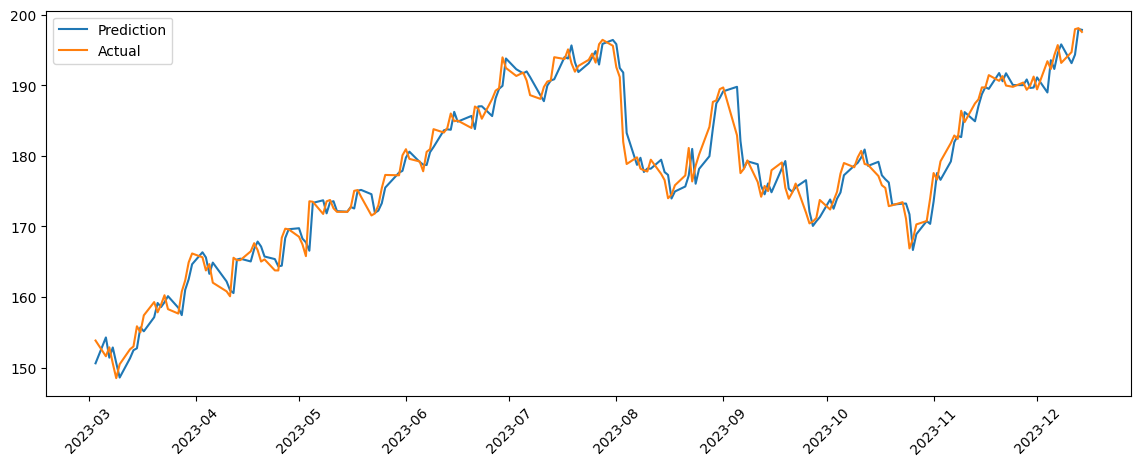

In [ ]:
# Plot the predictions
date = pd.to_datetime(test_data.index)
plt.figure(figsize=(14, 5))
plt.plot(date, prediction, label='Prediction')
plt.plot(date, y_test, label='Actual')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.legend()
plt.show()


To check in detail, we show the first 30 days of the testing period.

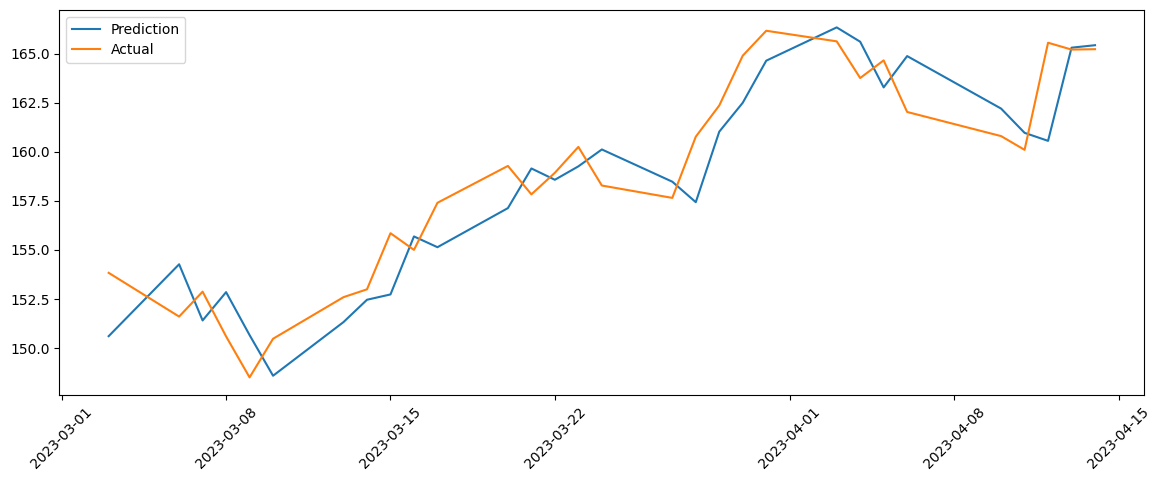

In [ ]:
# Plot the predictions
date = pd.to_datetime(test_data.index)
plt.figure(figsize=(14, 5))
plt.plot(date[:30], prediction[:30], label='Prediction')
plt.plot(date[:30], y_test[:30], label='Actual')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.show()